# **K-Fold training**


In [1]:
# Enviroment
isColab = False
colab_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"

isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 42

## **Loading Enviroment**


In [2]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive # type: ignore
    drive.mount("/gdrive")
    current_dir = colab_dir
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

# Define absolute paths
dataset_dir = os.path.join(current_dir, "dataset")
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")

print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## **Import Libraries**


In [3]:
# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard 
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.") 

os.makedirs("models", exist_ok=True)  

%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
from torch.optim import AdamW

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.9.1+cu130
Device: cuda


### **Preparing Dataset for colab**

In [4]:
if isColab:
    drive_dataset_dir = os.path.join(current_dir, "dataset")
    local_dataset_dir = "/content/dataset"

    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")

    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

## ⏳ **Data Loading**


In [5]:
# Loader parameters
BATCH_SIZE = 16
GRAD_ACCUMULATION_STEPS = 2

NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

IMG_RESIZE = (384, 384)
INPUT_SHAPE = (3, *IMG_RESIZE)

### **Definitions**


In [6]:
SAMPLES_TO_IGNORE = [
    "img_0001.png",
    "img_0005.png",
    "img_0008.png",
    "img_0012.png",
    "img_0018.png",
    "img_0020.png",
    "img_0022.png",
    "img_0027.png",
    "img_0028.png",
    "img_0036.png",
    "img_0044.png",
    "img_0047.png",
    "img_0048.png",
    "img_0052.png",
    "img_0062.png",
    "img_0078.png",
    "img_0085.png",
    "img_0090.png",
    "img_0094.png",
    "img_0095.png",
    "img_0126.png",
    "img_0129.png",
    "img_0130.png",
    "img_0133.png",
    "img_0136.png",
    "img_0138.png",
    "img_0148.png",
    "img_0150.png",
    "img_0155.png",
    "img_0159.png",
    "img_0161.png",
    "img_0175.png",
    "img_0178.png",
    "img_0179.png",
    "img_0180.png",
    "img_0184.png",
    "img_0187.png",
    "img_0189.png",
    "img_0193.png",
    "img_0196.png",
    "img_0222.png",
    "img_0251.png",
    "img_0254.png",
    "img_0263.png",
    "img_0268.png",
    "img_0286.png",
    "img_0293.png",
    "img_0313.png",
    "img_0319.png",
    "img_0333.png",
    "img_0342.png",
    "img_0344.png",
    "img_0346.png",
    "img_0355.png",
    "img_0368.png",
    "img_0371.png",
    "img_0376.png",
    "img_0380.png",
    "img_0390.png",
    "img_0393.png",
    "img_0407.png",
    "img_0410.png",
    "img_0415.png",
    "img_0424.png",
    "img_0443.png",
    "img_0453.png",
    "img_0459.png",
    "img_0463.png",
    "img_0486.png",
    "img_0497.png",
    "img_0498.png",
    "img_0499.png",
    "img_0509.png",
    "img_0521.png",
    "img_0530.png",
    "img_0531.png",
    "img_0533.png",
    "img_0537.png",
    "img_0540.png",
    "img_0544.png",
    "img_0547.png",
    "img_0557.png",
    "img_0558.png",
    "img_0560.png",
    "img_0565.png",
    "img_0567.png",
    "img_0572.png",
    "img_0578.png",
    "img_0580.png",
    "img_0586.png",
    "img_0602.png",
    "img_0603.png",
    "img_0607.png",
    "img_0609.png",
    "img_0614.png",
    "img_0620.png",
    "img_0623.png",
    "img_0629.png",
    "img_0635.png",
    "img_0639.png",
    "img_0643.png",
    "img_0644.png",
    "img_0645.png",
    "img_0646.png",
    "img_0656.png",
    "img_0657.png",
    "img_0658.png",
    "img_0670.png",
    "img_0673.png",
    "img_0675.png",
]

In [7]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

# Remove cursed images
full_df = full_df[~full_df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(
    drop=True
)

# Label mapping
class_names = sorted(full_df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
full_df["label_index"] = full_df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [8]:
def make_loader(ds, batch_size, shuffle, drop_last=False):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(6, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
        persistent_workers=isWsl,
    )

In [9]:
from scipy import ndimage
from PIL import Image, ImageOps
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from torchvision.transforms import v2 as transforms


class MaskedFixedTileDataset(Dataset):
    """
    A Dataset class that extracts fixed-size patches from the center of tissue masks
    to preserve biological scale (magnification), rather than resizing variable crops.
    """

    def __init__(
        self, dataframe, img_dir, transforms=None, target_size=(224, 224), debug_max=None
    ):
        self.samples = []
        self.transforms = transforms
        self.img_dir = img_dir
        self.target_size = target_size

        # Handling inference mode (no labels) vs training mode
        self.is_inference_mode = False
        if dataframe is None or "label_index" not in dataframe.columns:
            self.is_inference_mode = True
            if dataframe is None:
                # If just a directory, list images
                img_names = sorted(
                    [f for f in os.listdir(img_dir) if f.startswith("img_")]
                )
            else:
                img_names = dataframe["sample_index"].tolist()
            iterator = zip(img_names, [-1] * len(img_names))
            total_items = len(img_names)
        else:
            iterator = zip(dataframe["sample_index"], dataframe["label_index"])
            total_items = len(dataframe)

        print(
            f"Processing {total_items} images to extract fixed-size {target_size} tiles..."
        )

        count = 0
        for img_name, label in tqdm(iterator, total=total_items):
            if debug_max and count >= debug_max:
                break
            self._process_and_extract(img_name, label)
            count += 1

        print(f"Extraction complete. Total patches: {len(self.samples)}")

    def _process_and_extract(self, img_name, label):
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.img_dir, img_name.replace("img_", "mask_"))

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except Exception as e:
            print(f"Warning: Could not load {img_name}: {e}")
            return

        img_w, img_h = image.size
        # Create binary mask for component labeling
        mask_arr = np.array(mask) > 0

        # Label connected components (blobs) in the mask
        labeled_mask, n_components = ndimage.label(mask_arr) # type: ignore

        for cid in range(1, n_components + 1):
            # Extract coordinates of the current blob
            ys, xs = np.where(labeled_mask == cid)

            # Filter out very small noise artifacts (< 50 pixels)
            if len(xs) < 50:
                continue

            # Calculate the centroid (center of mass) of the blob
            cy, cx = int(np.mean(ys)), int(np.mean(xs))

            # Define the fixed-size crop window around the centroid
            th, tw = self.target_size
            half_h, half_w = th // 2, tw // 2

            y1 = cy - half_h
            y2 = cy + half_h
            x1 = cx - half_w
            x2 = cx + half_w

            # Handle Edge Cases: Calculate intersection with the actual image
            img_y1, img_y2 = max(0, y1), min(img_h, y2)
            img_x1, img_x2 = max(0, x1), min(img_w, x2)

            # Extract the valid region from the image
            patch_crop = image.crop((img_x1, img_y1, img_x2, img_y2))

            # Calculate required padding if the crop extended beyond image bounds
            pad_left = max(0, -x1)
            pad_top = max(0, -y1)
            pad_right = max(0, x2 - img_w)
            pad_bottom = max(0, y2 - img_h)

            # If padding is needed, pad with white (255) which is standard background in histology
            if pad_left > 0 or pad_top > 0 or pad_right > 0 or pad_bottom > 0:
                patch = ImageOps.expand(
                    patch_crop,
                    border=(pad_left, pad_top, pad_right, pad_bottom),
                    fill=255,
                )
            else:
                patch = patch_crop

            # Ensure precise size match (e.g., if rounding errors occurred)
            if patch.size != self.target_size:
                patch = patch.resize(self.target_size, Image.BICUBIC) # type: ignore

            # Store in RAM (Efficient for ~2k images yielding ~10k-20k patches)
            self.samples.append(
                {"patch": np.array(patch), "label": label, "parent": img_name}
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        img = Image.fromarray(item["patch"])
        label = item["label"]

        if self.transforms:
            img = self.transforms(img)

        return img, label, item["parent"]

In [10]:
def compute_dataset_stats(dataset_class, dataframe, img_dir, target_size=IMG_RESIZE):
    """
    Computes channel-wise Mean and Std on the dataset without any normalization applied.
    """
    print("Computing dataset Mean and Std (this may take a moment)...")

    # define a simple transform that only converts to tensor
    basic_transforms = transforms.Compose(
        [transforms.Resize(IMG_RESIZE), transforms.ToTensor()]
    )

    # Instantiate dataset temporarily
    temp_ds = dataset_class(dataframe, img_dir, transforms=basic_transforms, target_size=target_size)
    loader = make_loader(temp_ds, batch_size=BATCH_SIZE, shuffle=False)

    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for data, _, _ in tqdm(loader):
        batch_samples = data.size(0)
        # Flatten H and W to calculate stats per channel
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print(f"\nDONE. Copy these values into your config:")
    print(f"NEW_MEAN = {mean.tolist()}") # type: ignore
    print(f"NEW_STD = {std.tolist()}") # type: ignore
    return mean.tolist(), std.tolist()  # type: ignore

In [11]:

print("Calculating stats on Training Data...")
    
# We use the class we just defined
custom_mean, custom_std = compute_dataset_stats(
        dataset_class=MaskedFixedTileDataset, 
        dataframe=full_df, 
        img_dir=train_set_dir,
        
    )

NORMALIZATION_MEAN = custom_mean
NORMALIZATION_STD = custom_std

Calculating stats on Training Data...
Computing dataset Mean and Std (this may take a moment)...
Processing 581 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/581 [00:00<?, ?it/s]

Extraction complete. Total patches: 4955


  0%|          | 0/310 [00:00<?, ?it/s]


DONE. Copy these values into your config:
NEW_MEAN = [0.6944385766983032, 0.6475514769554138, 0.6688598990440369]
NEW_STD = [0.07876788079738617, 0.12260245531797409, 0.09125622361898422]


### **Transforms**

In [12]:
# Define transformations

train_transform_tl = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
    ]
)

train_transform_ft = transforms.Compose(
    [
        transforms.RandomResizedCrop(
            IMG_RESIZE, scale=(0.8, 1.0), ratio=(0.8, 1.2), antialias=True
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),  # type: ignore
        transforms.RandomApply(
            [transforms.ElasticTransform(alpha=50.0, sigma=5.0)], p=0.25
        ),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))], p=0.2
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        transforms.RandAugment(num_ops=2, magnitude=6),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        transforms.RandomErasing(
            p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
    ]
)

data_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
    ]
)

#### **Example Visualizations**

In [13]:
example_dataset = MaskedFixedTileDataset(
    dataframe=full_df,
    img_dir=train_set_dir,
    transforms=data_transforms,
)

Processing 581 images to extract fixed-size (224, 224) tiles...


  0%|          | 0/581 [00:00<?, ?it/s]

Extraction complete. Total patches: 4955


In [14]:
def unnormalize(img, mean, std):
    img = np.array(img, copy=True)
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)


def show_mask_patch_effect(dataset, transforms, n=3):
    parents = list({s["parent"] for s in dataset.samples})
    parents = random.sample(parents, min(n, len(parents)))

    for img_name in parents:
        img_path = os.path.join(dataset.img_dir, img_name)
        mask_path = os.path.join(dataset.img_dir, img_name.replace("img_", "mask_"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) > 0

        labeled_mask, n_components = ndimage.label(mask)  # type: ignore

        fig = plt.figure(figsize=(4 * (n_components + 1), 5))
        gs = fig.add_gridspec(1, n_components + 1)

        # Originale + maschera
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(image)
        ax0.imshow(mask, alpha=0.4, cmap="Reds")
        ax0.set_title("Originale + Maschera")
        ax0.axis("off")

        col = 1
        for cid in range(1, n_components + 1):
            ys, xs = np.where(labeled_mask == cid)
            if len(xs) < 15:
                continue

            x1, x2 = xs.min(), xs.max()
            y1, y2 = ys.min(), ys.max()

            patch = image[y1:y2, x1:x2]
            patch_pil = Image.fromarray(patch)

            train_img = transforms(patch_pil)
            train_img = unnormalize(train_img.numpy(), NORMALIZATION_MEAN, NORMALIZATION_STD)

            ax = fig.add_subplot(gs[col])
            ax.imshow(np.transpose(train_img, (1, 2, 0)))
            ax.set_title(f"Patch {cid}")
            ax.axis("off")
            col += 1

        plt.suptitle(f"{img_name} – Patch estratte dai blob", fontsize=14)
        plt.show()

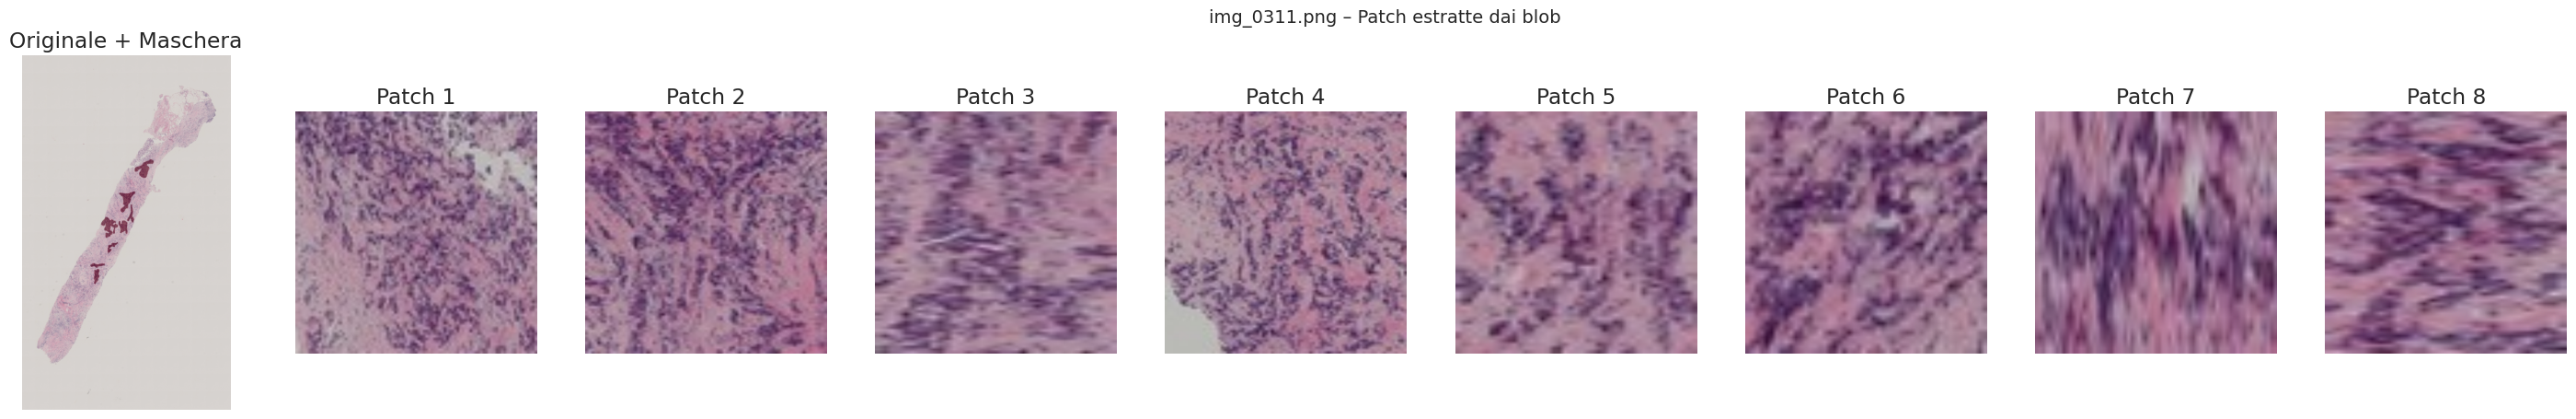

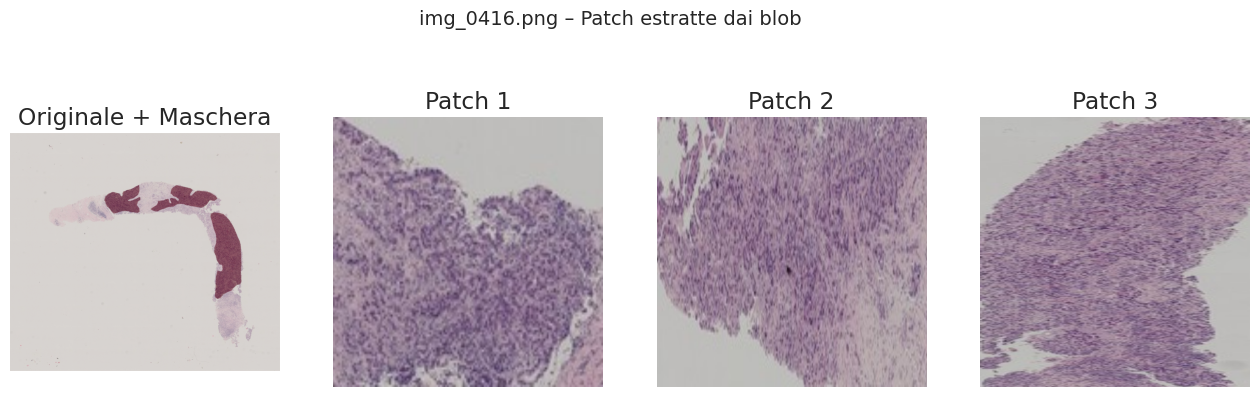

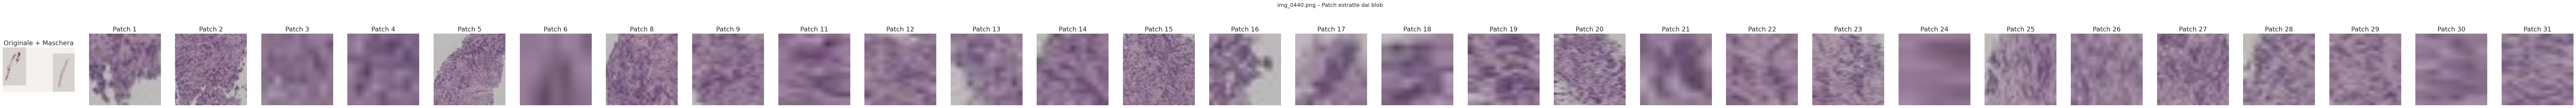

In [15]:
show_mask_patch_effect(
    dataset=example_dataset,
    transforms=train_transform_tl,
    n=3,
)

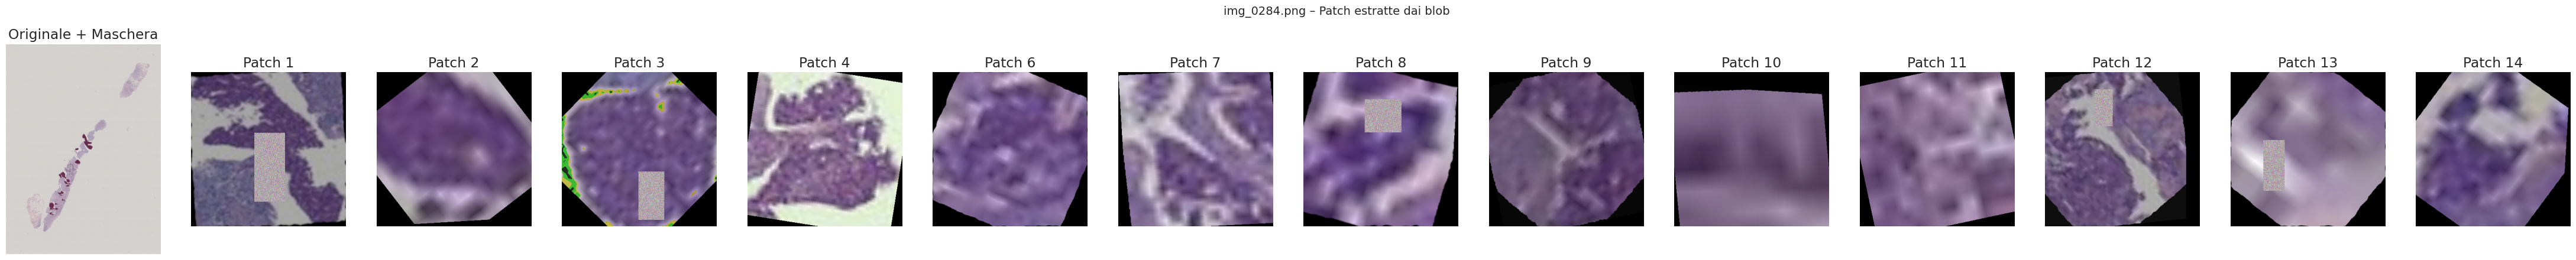

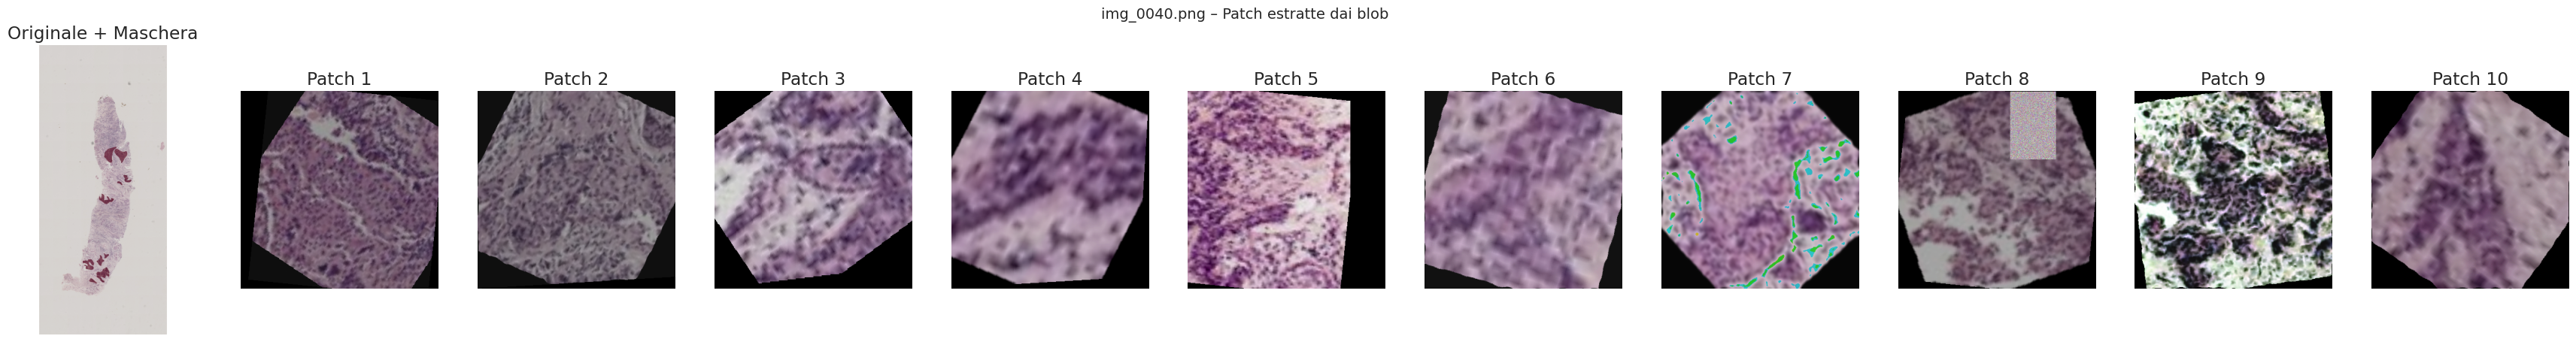

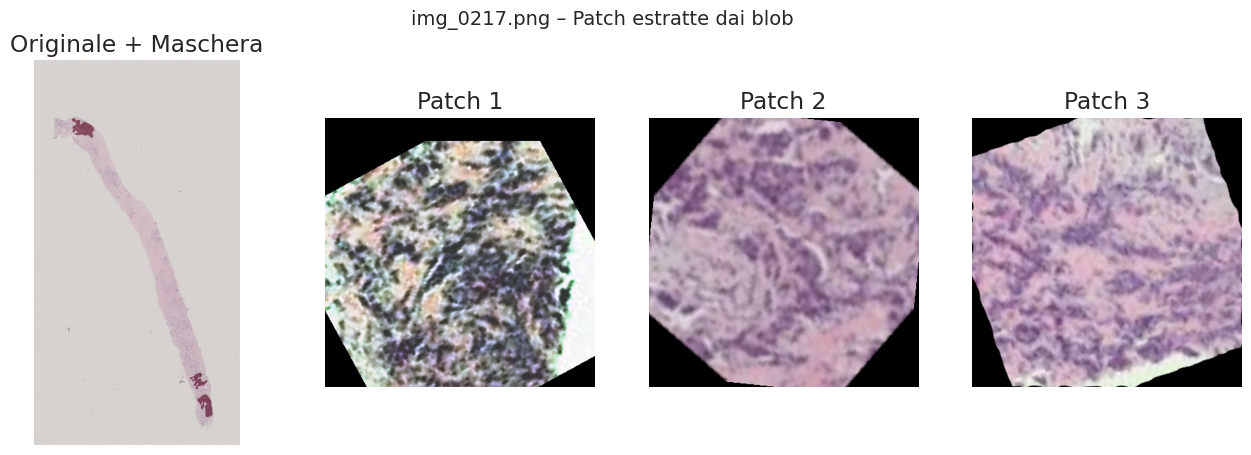

In [16]:
show_mask_patch_effect(
    dataset=example_dataset,
    transforms=train_transform_ft,
    n=3,
)

## 🧮 **Network Parameters**


In [17]:
EXPERIMENT_NAME = "densenet121_384p"
NET_NAME = "densenet121"

# Training parameters
LEARNING_RATE = 3e-4
TL_EPOCHS = 70
TL_PATIENCE = 5
TL_DROPOUT_RATE = 0.45
TL_WEIGHT_DECAY = 1e-2

# Fine tuning parameters
FT_EPOCHS = 100
FT_PATIENCE = 12
FT_LEARNING_RATE = 2e-5
FT_WEIGHT_DECAY = 1e-3
FT_DROPOUT_RATE = 0.35
N_LAYERS_TO_UNFREEZE = 20
MIXUP_ALPHA = 0.2

FOCAL_LOSS_GAMMA = 1.5

VERBOSE = 5
K_FOLD = 5

## 🧠 **Training Functions**


In [18]:
import numpy as np
import torch


def mixup_data(x, y, alpha=0.2, device="cuda"):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calculates weighted loss for mixed targets"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [19]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, mixup_alpha=0.0, grad_accumulation_steps=1):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for idx, (inputs, targets, _) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        if mixup_alpha > 0:
            # Generate mixed inputs
            inputs, targets_a, targets_b, lam = mixup_data(
                inputs, targets, mixup_alpha, device
            )

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")): # type: ignore
                logits = model(inputs)
                # Calculate loss mixing both targets
                loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        else:
            # Standard training
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")): # type: ignore
                logits = model(inputs)
                loss = criterion(logits, targets)

        # Backpropagation
        loss = loss / grad_accumulation_steps
        scaler.scale(loss).backward()

        # We only update weights every 'accumulation_steps' OR at the very last batch
        if (idx + 1) % grad_accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()

            # Reset gradients for the next accumulation cycle
            optimizer.zero_grad(set_to_none=True)

        running_loss += (loss.item() * grad_accumulation_steps) * inputs.size(0)

        preds = logits.argmax(dim=1)
        # If mixed, use targets_a for rough accuracy estimation
        current_targets = targets_a if mixup_alpha > 0 else targets # type: ignore
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(current_targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [20]:
import torch.nn.functional as F


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate one epoch with test time augmentation

    Args:
        model (torch.nn.Module): model to validate
        val_loader (torch.utils.data.DataLoader): dataset loader
        criterion (torch.nn.modules.loss._Loss): criterion
        device (torch.device): device
    """

    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")): # type: ignore
                # TTA Strategy:
                # 1. Original
                logits_orig = model(inputs)
                out1 = F.softmax(logits_orig, dim=1)

                # 2. Horizontal Flip
                inputs_hf = torch.flip(inputs, dims=[3])
                out2 = F.softmax(model(inputs_hf), dim=1)

                # 3. Vertical Flip
                inputs_vf = torch.flip(inputs, dims=[2])
                out3 = F.softmax(model(inputs_vf), dim=1)

                # Average predictions
                avg_probs = (out1 + out2 + out3) / 3.0

            # Calculate Loss OUTSIDE autocast for numerical stability
            # Use float32 for loss computation
            loss = criterion(logits_orig.float(), targets)
                
            running_loss += loss.item() * inputs.size(0)

            preds = avg_probs.argmax(dim=1)

            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1


In [21]:
from torch.optim.swa_utils import AveragedModel, update_bn


def fit(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    optimizer,
    scaler,
    device,
    scheduler=None,
    patience=0,
    evaluation_metric="val_f1",
    mode="max",
    restore_best_weights=True,
    writer=None,
    verbose=1,
    experiment_name="",
    mixup_alpha=0.0,
    use_swa=False,
    swa_start_epoch=10,
    grad_accumulation_steps=1,
)->tuple[torch.nn.Module, dict]:
    """
    Fit the provided model

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        epochs (int): Number of training epochs.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scaler (torch.cuda.amp.GradScaler): Gradient scaler for mixed precision training.
        device (torch.device): Device to run the training on.
        scheduler (torch.optim.lr_scheduler._LRScheduler or torch.optim.lr_scheduler.ReduceLROnPlateau, optional): Learning rate scheduler. Defaults to None.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 0.
        evaluation_metric (str, optional): Metric to evaluate for early stopping and best model selection. Defaults to "val_f1".
        mode (str, optional): One of {"min", "max"}. In "min" mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing. Defaults to "max".
        restore_best_weights (bool, optional): Whether to restore model weights from the epoch with the best value of the monitored quantity. Defaults to True.
        writer (torch.utils.tensorboard.SummaryWriter, optional): TensorBoard writer for logging. Defaults to None.
        verbose (int, optional): Verbosity level. Defaults to 1.
        experiment_name (str, optional): Name of the experiment for saving models. Defaults to "".
        mixup_alpha (float, optional): Alpha value for MixUp data augmentation. Defaults to 0.0.
        use_swa (bool, optional): Whether to use Stochastic Weight Averaging (SWA). Defaults to False.
        swa_start_epoch (int, optional): Epoch to start averaging for SWA. Defaults to 10.

    Returns:
        tuple[torch.nn.Module, dict]: The trained model and training history.
    """

    history = {"train_loss": [], "train_f1": [], "val_loss": [], "val_f1": []}

    best_metric = float("-inf") if mode == "max" else float("inf")
    best_epoch = 0
    patience_counter = 0

    # Initialize SWA Model if enabled
    if use_swa:
        print(f"SWA Enabled. Averaging will start after epoch {swa_start_epoch}.")
        swa_model = AveragedModel(model)
    else:
        swa_model = None

    print(f"Training {epochs} epochs (MixUp: {mixup_alpha}, SWA: {use_swa})...")
    for epoch in range(1, epochs + 1):
        train_loss, _, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, mixup_alpha, grad_accumulation_steps)
        val_loss, _, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

        # 2. Update SWA (if active and past start epoch)
        if use_swa and epoch >= swa_start_epoch:
            swa_model.update_parameters(model)

        if scheduler is not None:
            # If using ReduceLROnPlateau, step based on validation metric
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)
            else:
                # If using CosineAnnealing, step based on epoch
                scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        if writer is not None:
            writer.add_scalar("Loss/Training", train_loss, epoch)
            writer.add_scalar("F1/Training", train_f1, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("F1/Validation", val_f1, epoch)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | "
                f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f} | "
                f"LR: {scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]['lr']:.6f}"
            )

        current_metric = history[evaluation_metric][-1]
        is_improvement = (
            (current_metric > best_metric)
            if mode == "max"
            else (current_metric < best_metric)
        )

        if is_improvement:
            best_metric = current_metric
            best_epoch = epoch
            torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and patience > 0:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    # Handle SWA Finalization
    if use_swa:
        print("Finalizing SWA Batch Normalization statistics...")
        # We need to compute BN stats for the averaged weights using the train loader
        update_bn(train_loader, swa_model, device=device)

        # Save SWA model
        torch.save(swa_model.state_dict(), f"models/{experiment_name}_model.pt")
        print(f"SWA model saved to models/{experiment_name}_model.pt")

        # Return SWA model as the primary model
        return swa_model, history

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(
            f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}"
        )
    elif patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    if writer is not None:
        writer.close()

    return model, history

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def analyze_performance(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    print("Generating predictions for Confusion Matrix...")

    with torch.no_grad():
        for inputs, labels, _ in tqdm(loader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- 1. Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize by row (True Label) to see recall percentages
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("True Label (Ground Truth)")
    plt.xlabel("Predicted Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # --- 2. Classification Report ---
    print("\n" + "=" * 60)
    print("DETAILED CLASSIFICATION REPORT")
    print("=" * 60)
    print(
        classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    )

    return cm

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        # Alpha should be the class weights you already calculated
        # If alpha is None, no class weighting is applied
        self.alpha = alpha

    def forward(self, inputs, targets):
        # Clamp inputs to prevent overflow in exp()
        inputs = torch.clamp(inputs, min=-100, max=100)
        
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)  # prevents nans when probability is 0
        
        # Add small epsilon to prevent numerical issues
        pt = torch.clamp(pt, min=1e-7, max=1.0)
        
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


In [24]:
# Plot TL vs FT
def plot_history(tl_history, ft_history):
    epochs_tl = len(tl_history["val_f1"])
    epochs_ft = len(ft_history["val_f1"])

    plt.figure(figsize=(14, 5))

    # F1
    plt.subplot(1, 2, 1)
    plt.plot(tl_history["train_f1"], label="Train F1 TL")
    plt.plot(tl_history["val_f1"], label="Val F1 TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_f1"],
        label="Train F1 FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft), ft_history["val_f1"], label="Val F1 FT"
    )
    plt.xlabel("Epoch")
    plt.ylabel("F1 macro")
    plt.title("Andamento F1 TL+FT")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(tl_history["train_loss"], label="Train Loss TL")
    plt.plot(tl_history["val_loss"], label="Val Loss TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_loss"],
        label="Train Loss FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["val_loss"],
        label="Val Loss FT",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Andamento Loss TL+FT")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## 🛠️ **Transfer Learning**


In [25]:
class EfficientNetCustom(nn.Module):
    """
    Instantiates EfficientNet-B0 with ImageNet weights.
    Replaces the classifier head with a high-dropout dense layer to prevent overfitting.
    """

    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        self.backbone = torchvision.models.efficientnet_v2_s(weights=self.weights)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(in_features, self.num_classes),  # type: ignore
        )
        self.freeze_backbone()
    
    def freeze_backbone(self):
        # Freeze all layers except the classifier head
        for name, param in self.backbone.named_parameters():
            if not name.startswith("classifier"):
                param.requires_grad = False
        # Ensure classifier params are trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_layers, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return
        # Unfreeze the last n_layers of the backbone (excluding classifier which is already trainable)
        child_counter = 0
        for child in reversed(list(self.backbone.children())):
            child_counter += 1
            if child_counter <= n_layers:
                for param in child.parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [26]:
class DenseNetCustom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.DenseNet121_Weights.DEFAULT
        self.backbone = torchvision.models.densenet121(weights=self.weights)

        # DenseNet classifier is stored in .classifier
        in_features = self.backbone.classifier.in_features

        # Replace Classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate), 
            nn.Linear(in_features, num_classes)
        )

        self.freeze_backbone()

    def freeze_backbone(self):
        # Freeze all feature layers
        for param in self.backbone.features.parameters():
            param.requires_grad = False
        # Unfreeze classifier
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_layers, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return

        # Keep classifier trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

        # Get all named parameters in features (in order)
        feature_params = list(self.backbone.features.named_parameters())
        
        if n_layers <= 0:
            return
        
        # Unfreeze the last n_layers parameters
        params_to_unfreeze = feature_params[-n_layers:]
        
        for name, param in params_to_unfreeze:
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [27]:
class CustomNet(nn.Module):
    """
    Wrapper that can interchange between DenseNetCustom and EfficientNetCustom.
    Keeps the same constructor signature used in the notebook:
    CustomNet(num_classes, dropout_rate, backbone=...)
    """

    def __init__(self, num_classes, dropout_rate=0.4, backbone="densenet121"):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.backbone_name = backbone.lower()

        if self.backbone_name in ("densenet", "densenet121"):
            self.backbone = DenseNetCustom(num_classes=num_classes, dropout_rate=dropout_rate)
        elif self.backbone_name in ("efficientnet", "efficientnet_v2s", "efficientnetv2s"):
            self.backbone = EfficientNetCustom(num_classes=num_classes, dropout_rate=dropout_rate)
        else:
            raise ValueError(f"Unsupported backbone '{backbone}'. Use 'densenet' or 'efficientnet'.")

    def freeze_backbone(self):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "freeze_backbone"):
            self.backbone.freeze_backbone()

    def unfreeze_backbone(self, n_layers, all=False):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "unfreeze_backbone"):
            self.backbone.unfreeze_backbone(n_layers, all=all)

    def forward(self, x):
        return self.backbone(x)

## **K Fold Routine**

In [28]:
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn.utils.class_weight import compute_class_weight


def run_k_fold_training(full_df, n_splits=5, base_experiment_name="efficientnet_v2s", writer=None):
    """
    Orchestrates the complete K-Fold Cross Validation pipeline.
    For each fold:
      1. Splits data
      2. Runs Transfer Learning (TL) -> Warmup
      3. Runs Fine Tuning (FT) -> Optimization with MixUp & SWA
    """

    # Initialize K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    # Store results
    fold_results = []

    print(f"Starting {n_splits}-Fold Cross Validation...")
    print(f"Total Epochs per Fold: {TL_EPOCHS} (TL) + {FT_EPOCHS} (FT)")

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(
        skf.split(full_df, full_df["label_index"])
    ):
        print(f"\n{'='*40}")
        print(f"FOLD {fold+1}/{n_splits}")
        print(f"{'='*40}")

        # --- 1. DATA PREPARATION ---
        fold_train_df = full_df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = full_df.iloc[val_idx].reset_index(drop=True)

        # Calculate Class Weights for this specific fold
        # (Crucial: Weights change slightly between folds)
        fold_class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.arange(num_classes),
            y=fold_train_df["label_index"].values,
        )
        fold_weights_tensor = torch.tensor(fold_class_weights, dtype=torch.float).to(
            device
        )

        # Re-initialize Loss with specific fold weights
        fold_criterion = FocalLoss(alpha=fold_weights_tensor, gamma=FOCAL_LOSS_GAMMA)

        # Create Datasets
        # Note: We re-instantiate datasets to ensure clean separation
        train_ds = MaskedFixedTileDataset(
            fold_train_df,
            train_set_dir,
            transforms=train_transform_tl,
            target_size=IMG_RESIZE,
            debug_max=None,
        )
        val_ds = MaskedFixedTileDataset(
            fold_val_df,
            train_set_dir,
            transforms=data_transforms,
            target_size=IMG_RESIZE,
            debug_max=None,
        )

        train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True)
        val_loader = make_loader(val_ds, BATCH_SIZE, shuffle=False)

        # --- 2. PHASE 1: TRANSFER LEARNING (Warm-Up) ---
        print(f"Fold {fold+1} >> Phase 1: Transfer Learning (Frozen Backbone)")

        # Initialize Fresh Model
        model = CustomNet(num_classes, TL_DROPOUT_RATE, backbone=NET_NAME).to(device)
        model.freeze_backbone()

        optimizer_tl = AdamW(
            model.parameters(), lr=LEARNING_RATE, weight_decay=TL_WEIGHT_DECAY
        )
        scaler_tl = torch.amp.GradScaler(enabled=(device.type == "cuda")) # type: ignore
        scheduler_tl = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_tl, T_max=TL_EPOCHS, eta_min=1e-6
        )

        # Run Fit (TL)
        tl_model, tl_hystory = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=TL_EPOCHS,
            criterion=fold_criterion,
            optimizer=optimizer_tl,
            scaler=scaler_tl,
            device=device,
            scheduler=scheduler_tl,
            experiment_name=f"{base_experiment_name}_fold{fold+1}_tl",
            patience=TL_PATIENCE,
            mixup_alpha=0.0,
            use_swa=False,
            verbose=VERBOSE,
            writer=writer,
            grad_accumulation_steps=GRAD_ACCUMULATION_STEPS,
        )

        # --- 3. PHASE 2: FINE TUNING (Full Training) ---
        print(f"Fold {fold+1} >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)")

        # Unfreeze
        tl_model.unfreeze_backbone(N_LAYERS_TO_UNFREEZE, all=False)

        total_params = sum(p.numel() for p in tl_model.parameters())
        trainable_params = sum(p.numel() for p in tl_model.parameters() if p.requires_grad)

        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Frozen parameters: {total_params - trainable_params:,}")

        # Switch Transforms to Heavy Augmentation
        train_ds.transforms = train_transform_ft  # Update dataset transform in-place

        # New Optimizer (Lower LR)
        optimizer_ft = AdamW(
            model.parameters(), lr=FT_LEARNING_RATE, weight_decay=FT_WEIGHT_DECAY
        )
        scaler_ft = torch.amp.GradScaler(enabled=(device.type == "cuda")) # type: ignore
        scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_ft, T_max=FT_EPOCHS, eta_min=1e-6
        )

        # Run Fit (FT)
        # Note: We use the SWA Start logic here.
        # If Epochs=200, start averaging around 150.
        swa_start = int(FT_EPOCHS * 0.75)

        ft_model, ft_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=FT_EPOCHS,
            criterion=fold_criterion,
            optimizer=optimizer_ft,
            scaler=scaler_ft,
            device=device,
            scheduler=scheduler_ft,
            experiment_name=f"{base_experiment_name}_fold{fold+1}_ft",
            patience=FT_PATIENCE,
            mixup_alpha=MIXUP_ALPHA,
            use_swa=False,
            swa_start_epoch=swa_start,
            verbose=VERBOSE,
            writer=writer,
            grad_accumulation_steps=GRAD_ACCUMULATION_STEPS,
        )

        best_f1 = max(ft_history["val_f1"])
        print(f"Fold {fold+1} Completed. Best F1: {best_f1:.4f}")
        fold_results.append(best_f1)

        analyze_performance(ft_model, val_loader, device, class_names)
        plot_history(tl_hystory, ft_history)

        # Cleanup to free GPU memory for next fold
        del (
            tl_model,
            ft_model,
            optimizer_tl,
            optimizer_ft,
            scaler_tl,
            scaler_ft,
            train_loader,
            val_loader,
            train_ds,
            val_ds,
        )
        torch.cuda.empty_cache()
        gc.collect()

    # --- SUMMARY ---
    print(f"\n{'='*40}")
    print("CROSS VALIDATION COMPLETE")
    print(f"Folds: {fold_results}")
    print(f"Average F1: {np.mean(fold_results):.4f} (+/- {np.std(fold_results):.4f})")
    print(f"{'='*40}")

## **Training**

In [29]:
# Setup training

writer = SummaryWriter("./" + logs_dir + "/" + EXPERIMENT_NAME)

Starting 5-Fold Cross Validation...
Total Epochs per Fold: 70 (TL) + 100 (FT)

FOLD 1/5
Processing 464 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/464 [00:00<?, ?it/s]

Extraction complete. Total patches: 3982
Processing 117 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/117 [00:00<?, ?it/s]

Extraction complete. Total patches: 973
Fold 1 >> Phase 1: Transfer Learning (Frozen Backbone)
Training 70 epochs (MixUp: 0.0, SWA: False)...
Epoch   1/70 | Train: Loss=0.9523, F1=0.2639 | Val: Loss=0.8407, F1=0.1580 | LR: 0.000300
Epoch   5/70 | Train: Loss=0.8359, F1=0.3451 | Val: Loss=0.7827, F1=0.3126 | LR: 0.000296
Epoch  10/70 | Train: Loss=0.7846, F1=0.3825 | Val: Loss=0.7856, F1=0.3232 | LR: 0.000285
Epoch  15/70 | Train: Loss=0.7844, F1=0.3924 | Val: Loss=0.7896, F1=0.3133 | LR: 0.000267
Early stopping triggered after 17 epochs.
Best model restored from epoch 12 with val_f1 0.3460
Fold 1 >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)
Total parameters: 6,957,956
Trainable parameters: 491,908
Frozen parameters: 6,466,048
Training 100 epochs (MixUp: 0.2, SWA: False)...
Epoch   1/100 | Train: Loss=0.8053, F1=0.3172 | Val: Loss=0.7855, F1=0.3075 | LR: 0.000020
Epoch   5/100 | Train: Loss=0.7792, F1=0.3241 | Val: Loss=0.7889, F1=0.3011 | LR: 0.000020
Epoch  10/100 | Train: Loss=0.

Validating:   0%|          | 0/61 [00:00<?, ?it/s]

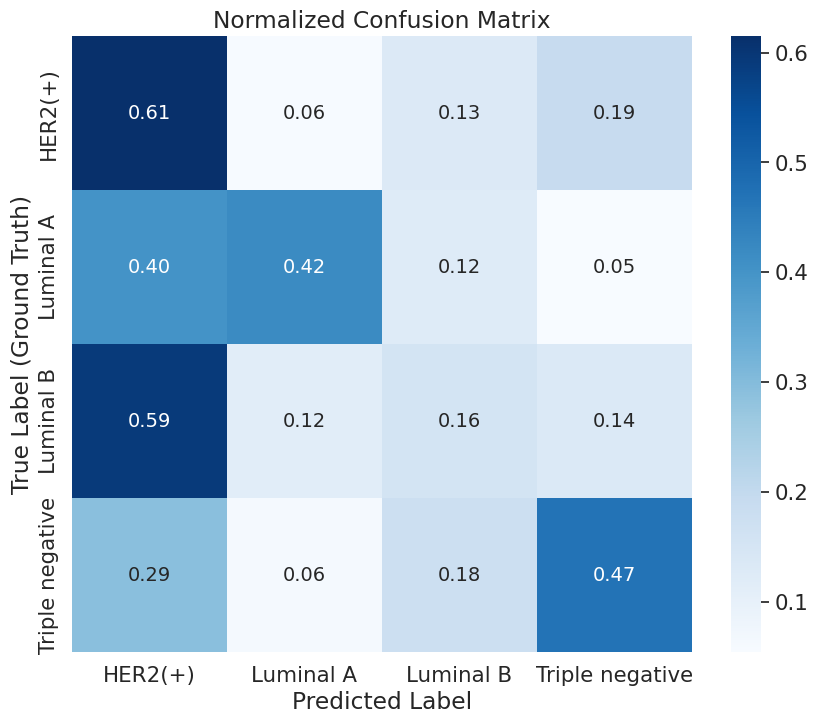


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        HER2(+)     0.3173    0.6148    0.4185       257
      Luminal A     0.6931    0.4199    0.5230       312
      Luminal B     0.3696    0.1569    0.2203       325
Triple negative     0.2500    0.4684    0.3260        79

       accuracy                         0.3875       973
      macro avg     0.4075    0.4150    0.3719       973
   weighted avg     0.4498    0.3875    0.3783       973



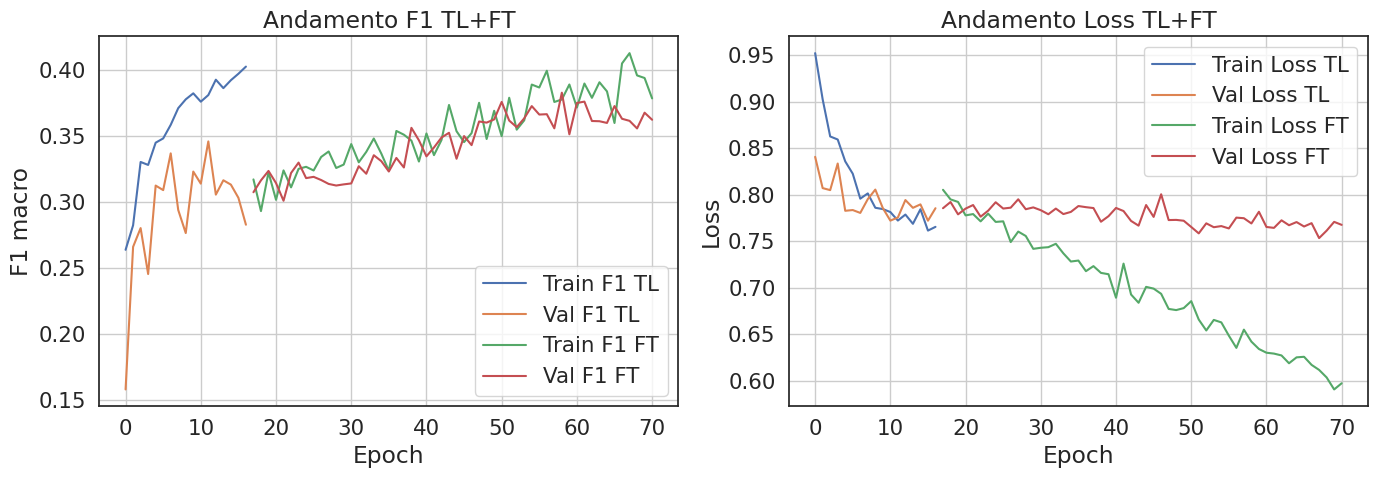


FOLD 2/5
Processing 465 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/465 [00:00<?, ?it/s]

Extraction complete. Total patches: 3866
Processing 116 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/116 [00:00<?, ?it/s]

Extraction complete. Total patches: 1089
Fold 2 >> Phase 1: Transfer Learning (Frozen Backbone)
Training 70 epochs (MixUp: 0.0, SWA: False)...
Epoch   1/70 | Train: Loss=0.9289, F1=0.2745 | Val: Loss=0.8736, F1=0.2378 | LR: 0.000300
Epoch   5/70 | Train: Loss=0.8118, F1=0.3677 | Val: Loss=0.8683, F1=0.2742 | LR: 0.000296
Early stopping triggered after 7 epochs.
Best model restored from epoch 2 with val_f1 0.2788
Fold 2 >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)
Total parameters: 6,957,956
Trainable parameters: 491,908
Frozen parameters: 6,466,048
Training 100 epochs (MixUp: 0.2, SWA: False)...
Epoch   1/100 | Train: Loss=0.8702, F1=0.2871 | Val: Loss=0.8608, F1=0.2533 | LR: 0.000020
Epoch   5/100 | Train: Loss=0.8219, F1=0.2994 | Val: Loss=0.8602, F1=0.2803 | LR: 0.000020
Epoch  10/100 | Train: Loss=0.7922, F1=0.3273 | Val: Loss=0.8597, F1=0.2916 | LR: 0.000020
Epoch  15/100 | Train: Loss=0.7657, F1=0.3250 | Val: Loss=0.8612, F1=0.2911 | LR: 0.000019
Epoch  20/100 | Train: Loss=0

Validating:   0%|          | 0/69 [00:00<?, ?it/s]

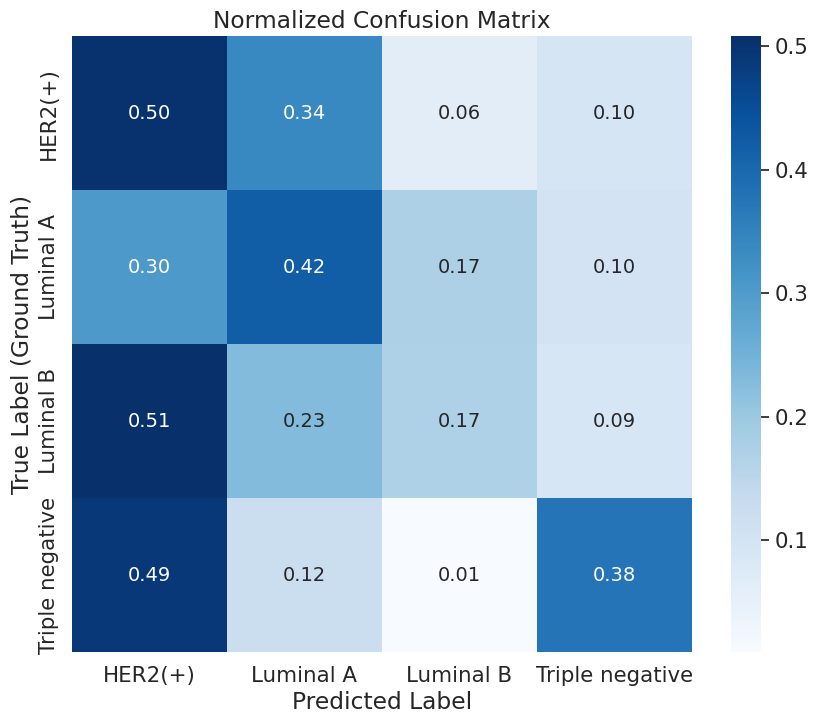


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        HER2(+)     0.3060    0.5033    0.3806       304
      Luminal A     0.3229    0.4187    0.3646       246
      Luminal B     0.5401    0.1709    0.2596       433
Triple negative     0.3008    0.3774    0.3347       106

       accuracy                         0.3398      1089
      macro avg     0.3674    0.3676    0.3349      1089
   weighted avg     0.4024    0.3398    0.3244      1089



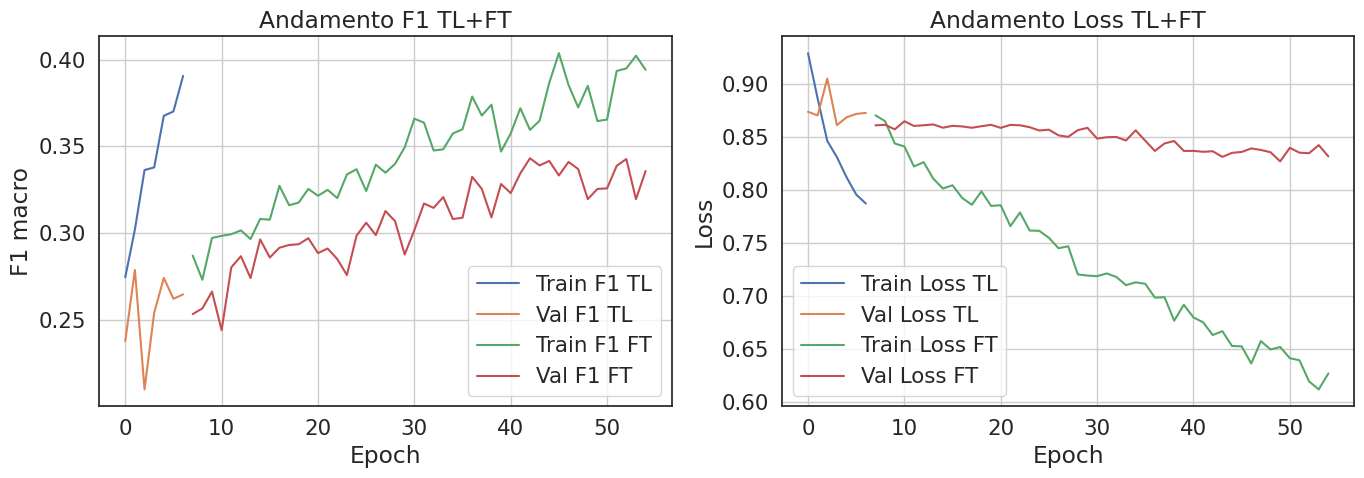


FOLD 3/5
Processing 465 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/465 [00:00<?, ?it/s]

Extraction complete. Total patches: 4057
Processing 116 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/116 [00:00<?, ?it/s]

Extraction complete. Total patches: 898
Fold 3 >> Phase 1: Transfer Learning (Frozen Backbone)
Training 70 epochs (MixUp: 0.0, SWA: False)...
Epoch   1/70 | Train: Loss=0.9291, F1=0.2661 | Val: Loss=0.8496, F1=0.2601 | LR: 0.000300
Epoch   5/70 | Train: Loss=0.8136, F1=0.3615 | Val: Loss=0.8025, F1=0.3495 | LR: 0.000296
Epoch  10/70 | Train: Loss=0.7783, F1=0.3799 | Val: Loss=0.8337, F1=0.2486 | LR: 0.000285
Early stopping triggered after 10 epochs.
Best model restored from epoch 5 with val_f1 0.3495
Fold 3 >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)
Total parameters: 6,957,956
Trainable parameters: 491,908
Frozen parameters: 6,466,048
Training 100 epochs (MixUp: 0.2, SWA: False)...
Epoch   1/100 | Train: Loss=0.8181, F1=0.3045 | Val: Loss=0.8061, F1=0.3252 | LR: 0.000020
Epoch   5/100 | Train: Loss=0.8092, F1=0.3037 | Val: Loss=0.7962, F1=0.3278 | LR: 0.000020
Epoch  10/100 | Train: Loss=0.7749, F1=0.3150 | Val: Loss=0.7974, F1=0.3100 | LR: 0.000020
Epoch  15/100 | Train: Loss=0.

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

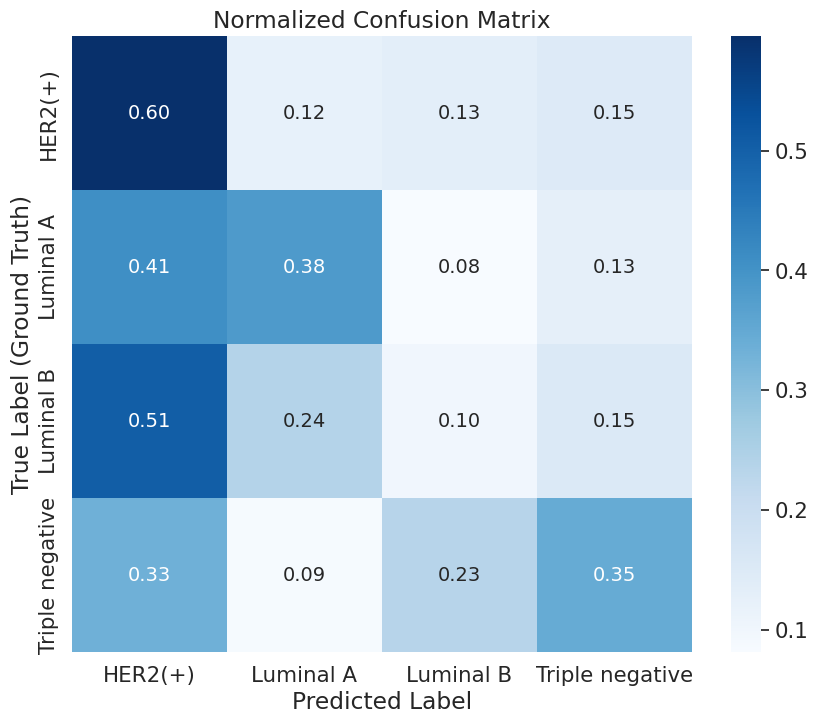


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        HER2(+)     0.3562    0.5954    0.4457       262
      Luminal A     0.4737    0.3837    0.4240       258
      Luminal B     0.2857    0.1010    0.1493       297
Triple negative     0.1918    0.3457    0.2467        81

       accuracy                         0.3486       898
      macro avg     0.3268    0.3565    0.3164       898
   weighted avg     0.3518    0.3486    0.3235       898



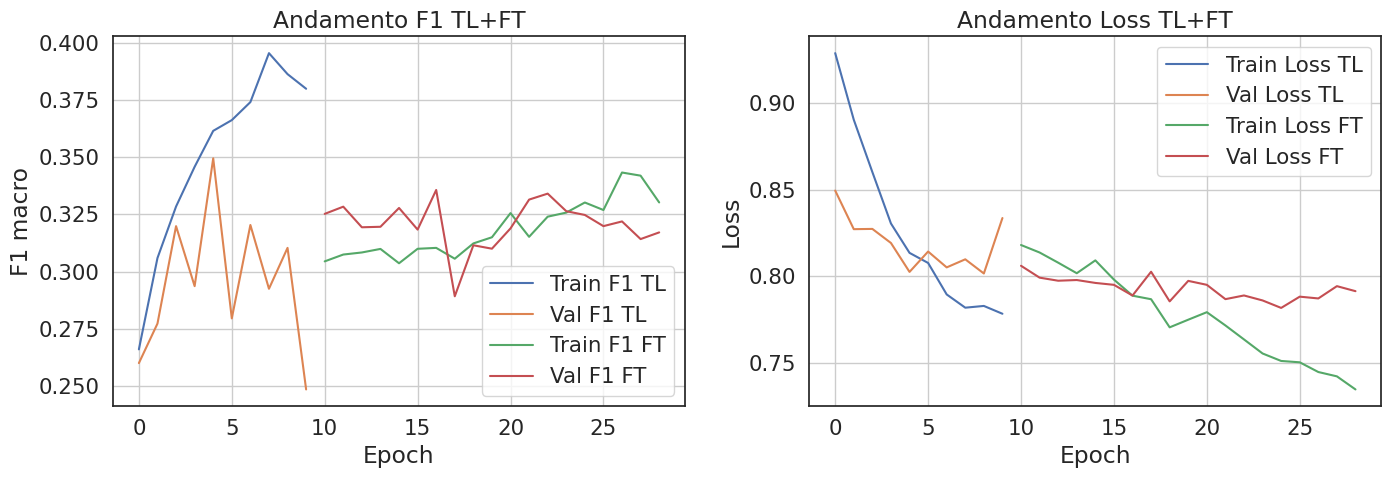


FOLD 4/5
Processing 465 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/465 [00:00<?, ?it/s]

Extraction complete. Total patches: 3870
Processing 116 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/116 [00:00<?, ?it/s]

Extraction complete. Total patches: 1085
Fold 4 >> Phase 1: Transfer Learning (Frozen Backbone)
Training 70 epochs (MixUp: 0.0, SWA: False)...
Epoch   1/70 | Train: Loss=0.9381, F1=0.2647 | Val: Loss=0.9183, F1=0.2602 | LR: 0.000300
Epoch   5/70 | Train: Loss=0.8151, F1=0.3363 | Val: Loss=0.8997, F1=0.3086 | LR: 0.000296
Epoch  10/70 | Train: Loss=0.7633, F1=0.4026 | Val: Loss=0.8808, F1=0.3512 | LR: 0.000285
Early stopping triggered after 13 epochs.
Best model restored from epoch 8 with val_f1 0.3803
Fold 4 >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)
Total parameters: 6,957,956
Trainable parameters: 491,908
Frozen parameters: 6,466,048
Training 100 epochs (MixUp: 0.2, SWA: False)...
Epoch   1/100 | Train: Loss=0.7809, F1=0.3168 | Val: Loss=0.8613, F1=0.3601 | LR: 0.000020
Epoch   5/100 | Train: Loss=0.7699, F1=0.3244 | Val: Loss=0.8673, F1=0.3499 | LR: 0.000020
Epoch  10/100 | Train: Loss=0.7565, F1=0.3104 | Val: Loss=0.8913, F1=0.3544 | LR: 0.000020
Epoch  15/100 | Train: Loss=0

Validating:   0%|          | 0/68 [00:00<?, ?it/s]

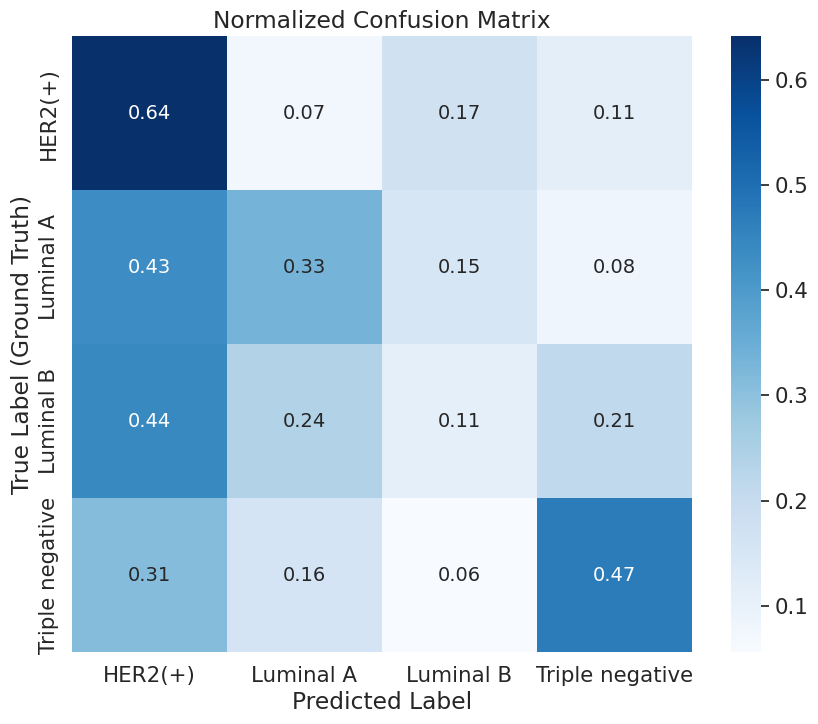


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        HER2(+)     0.4129    0.6412    0.5023       340
      Luminal A     0.3871    0.3333    0.3582       252
      Luminal B     0.2797    0.1087    0.1566       368
Triple negative     0.2995    0.4720    0.3665       125

       accuracy                         0.3696      1085
      macro avg     0.3448    0.3888    0.3459      1085
   weighted avg     0.3487    0.3696    0.3359      1085



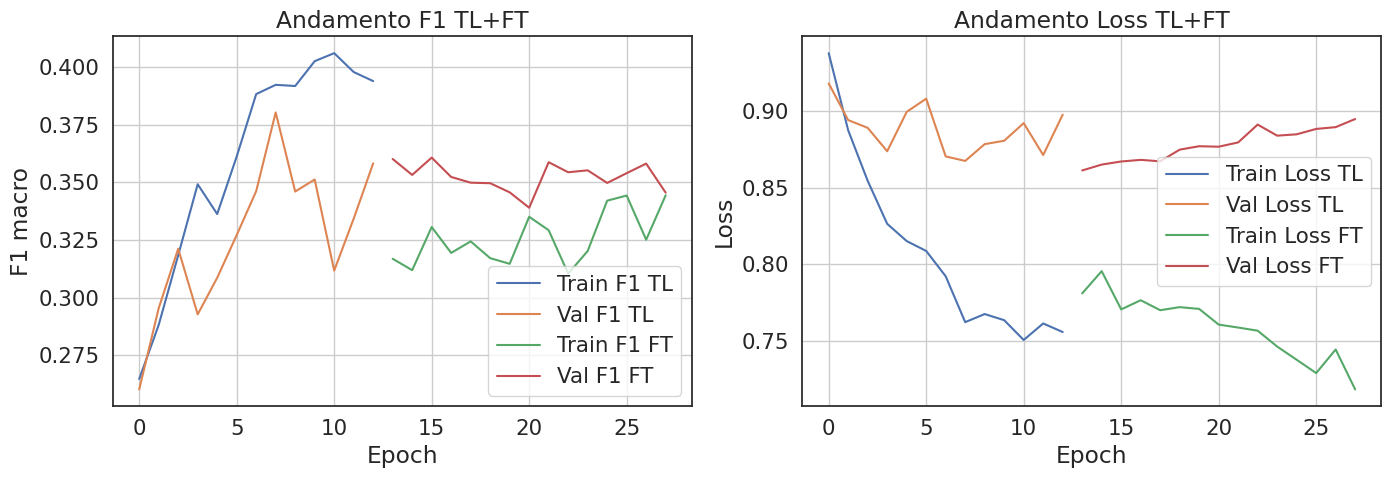


FOLD 5/5
Processing 465 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/465 [00:00<?, ?it/s]

Extraction complete. Total patches: 4045
Processing 116 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/116 [00:00<?, ?it/s]

Extraction complete. Total patches: 910
Fold 5 >> Phase 1: Transfer Learning (Frozen Backbone)
Training 70 epochs (MixUp: 0.0, SWA: False)...
Epoch   1/70 | Train: Loss=0.9384, F1=0.2520 | Val: Loss=0.9079, F1=0.2661 | LR: 0.000300
Epoch   5/70 | Train: Loss=0.8090, F1=0.3424 | Val: Loss=0.9234, F1=0.2998 | LR: 0.000296
Epoch  10/70 | Train: Loss=0.7498, F1=0.3957 | Val: Loss=0.9032, F1=0.3160 | LR: 0.000285
Early stopping triggered after 11 epochs.
Best model restored from epoch 6 with val_f1 0.3386
Fold 5 >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)
Total parameters: 6,957,956
Trainable parameters: 491,908
Frozen parameters: 6,466,048
Training 100 epochs (MixUp: 0.2, SWA: False)...
Epoch   1/100 | Train: Loss=0.7954, F1=0.3018 | Val: Loss=0.8888, F1=0.3334 | LR: 0.000020
Epoch   5/100 | Train: Loss=0.7726, F1=0.3261 | Val: Loss=0.8896, F1=0.3145 | LR: 0.000020
Epoch  10/100 | Train: Loss=0.7529, F1=0.3256 | Val: Loss=0.8878, F1=0.3267 | LR: 0.000020
Early stopping triggered after

Validating:   0%|          | 0/57 [00:00<?, ?it/s]

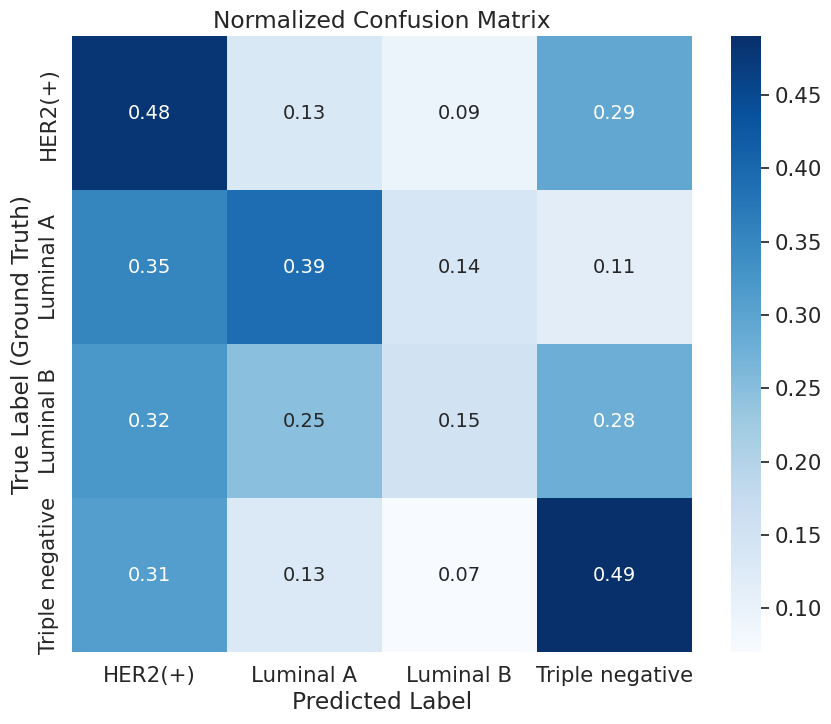


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        HER2(+)     0.3724    0.4811    0.4198       264
      Luminal A     0.4240    0.3915    0.4071       235
      Luminal B     0.4196    0.1511    0.2222       311
Triple negative     0.2042    0.4900    0.2882       100

       accuracy                         0.3462       910
      macro avg     0.3551    0.3784    0.3343       910
   weighted avg     0.3834    0.3462    0.3345       910



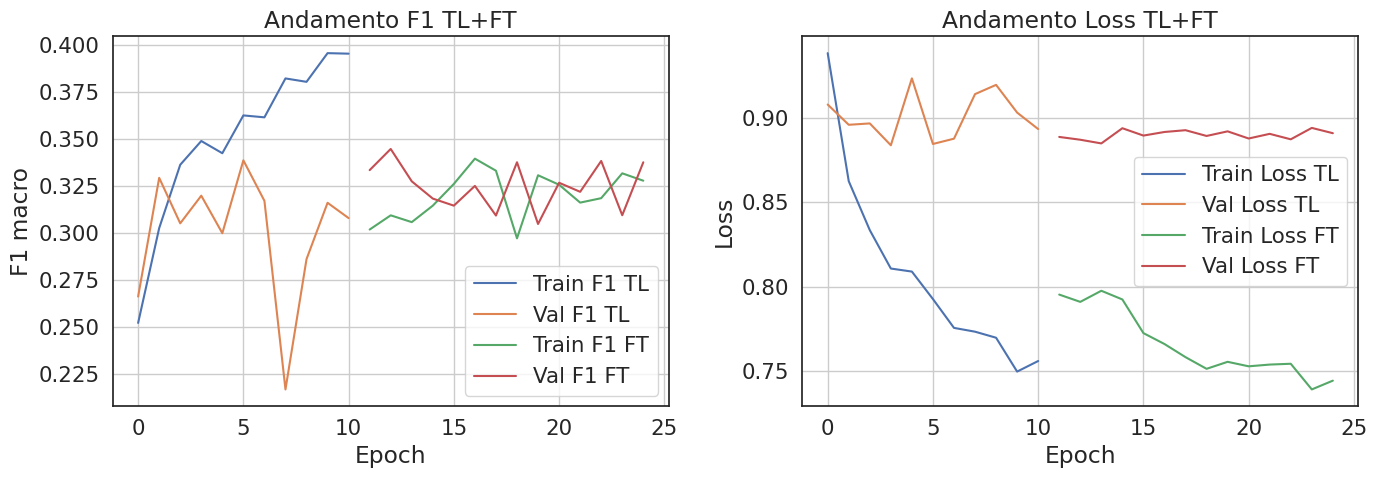


CROSS VALIDATION COMPLETE
Folds: [0.38300403905055813, 0.3431918014281554, 0.3356781466948975, 0.36072283588863113, 0.34468888836769995]
Average F1: 0.3535 (+/- 0.0169)
CPU times: user 4h 26min 19s, sys: 53min 7s, total: 5h 19min 27s
Wall time: 5h 1min 15s


In [30]:
%%time

run_k_fold_training(full_df, n_splits=K_FOLD, base_experiment_name=EXPERIMENT_NAME, writer=writer)

## **Inference on test data for kaggle**


In [31]:
def top_k_mean_aggregation(prob_matrix, k_percent=0.5):
    """
    Aggregates patch probabilities into a slide prediction by averaging
    only the most confident patches (Top-K%).

    Args:
        prob_matrix: Numpy array of shape [N_patches, N_classes]
        k_percent: Float (0.0 to 1.0). Percentage of patches to keep.
                   0.3 means we only average the top 30% scores.
    """
    n_patches = prob_matrix.shape[0]

    # Safety check: if slide has very few patches, keep at least 1
    k = max(1, int(n_patches * k_percent))

    # Sort probabilities for each class INDEPENDENTLY (Axis 0 = patches)
    # We want the highest probabilities for Class 0, Class 1, etc.
    sorted_probs = np.sort(prob_matrix, axis=0)

    # Take the top K (the last K elements in the sorted array)
    top_k_probs = sorted_probs[-k:, :]

    # Average them
    slide_score = np.mean(top_k_probs, axis=0)

    return slide_score

In [32]:
import torch.nn.functional as F
import gc


def generate_ensemble_submission(
    test_dir,
    base_experiment_name="efficientnet_v2s",
    num_folds=5,
    output_file="submission_ensemble.csv",
):
    """
    Loads K models, sums their probabilities, and performs Soft Voting.
    """

    # 1. Setup Test Dataset & Loader
    # We use the dataset once to establish the order of patches
    print(f"Preparing Test Dataset from {test_dir}...")
    test_ds = MaskedFixedTileDataset(
        dataframe=None,
        img_dir=test_dir,
        transforms=data_transforms,
        target_size=IMG_RESIZE,
        debug_max=None,
    )

    test_loader = make_loader(test_ds, BATCH_SIZE, shuffle=False)

    num_patches = len(test_ds)
    print(f"Total Patches to Process: {num_patches}")

    # matrix to store accumulated probabilities [N_patches, N_classes]
    # We initialize with zeros
    accumulated_probs = np.zeros((num_patches, num_classes), dtype=np.float32)

    # We need to store parent_ids to aggregate later
    # The loader is deterministic (shuffle=False), so we can extract them once
    all_parent_ids = []

    # 2. Iterate through each Fold Model
    for fold in range(1, num_folds + 1):
        model_path = f"models/{base_experiment_name}_fold{fold}_ft_model.pt"
        print(f"\n--- Loading Model {fold}/{num_folds}: {model_path} ---")

        # Load Model
        try:
            model = CustomNet(num_classes, FT_DROPOUT_RATE).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()
        except FileNotFoundError:
            print(f"⚠️ Warning: Model file {model_path} not found. Skipping.")
            continue

        # Inference Loop for this model
        fold_patch_probs = []

        with torch.no_grad():
            for inputs, _, parent_ids in tqdm(
                test_loader, desc=f"Inference Fold {fold}"
            ):
                inputs = inputs.to(device)

                # --- TTA Strategy (Same as Validation) ---
                # 1. Original
                out1 = F.softmax(model(inputs), dim=1)

                # 2. Horizontal Flip
                inputs_hf = torch.flip(inputs, dims=[3])
                out2 = F.softmax(model(inputs_hf), dim=1)

                # 3. Vertical Flip
                inputs_vf = torch.flip(inputs, dims=[2])
                out3 = F.softmax(model(inputs_vf), dim=1)

                # Average predictions for this model
                avg_probs = (out1 + out2 + out3) / 3.0

                # Store
                fold_patch_probs.extend(avg_probs.cpu().numpy())

                # Only collect parent_ids on the first fold (optimization)
                if fold == 1:
                    all_parent_ids.extend(parent_ids)

        # Add to global accumulator
        accumulated_probs += np.array(fold_patch_probs)

        # Cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()

    # 3. Average & Aggregate
    print("\nAveraging Ensembled Probabilities...")
    final_avg_probs = accumulated_probs / num_folds

    # Now we have [Patch, Probs]. We need [Slide, Probs]
    slide_probs = {}

    print("Aggregating Patches to Slides (Soft Voting)...")
    for i, pid in enumerate(all_parent_ids):
        if pid not in slide_probs:
            slide_probs[pid] = []
        slide_probs[pid].append(final_avg_probs[i])

    final_rows = []

    for img_name, prob_list in slide_probs.items():
        # Stack patches for this slide
        prob_matrix = np.array(prob_list)

        slide_avg = top_k_mean_aggregation(prob_matrix=prob_matrix, k_percent=0.3)

        # Argmax for final label
        pred_idx = np.argmax(slide_avg)
        pred_label = class_names[pred_idx]

        # Filename formatting
        sample_index = img_name  # Assuming format matches submission reqs

        final_rows.append({"sample_index": sample_index, "label": pred_label})

    # 4. Save Submission
    submission_df = pd.DataFrame(final_rows)
    submission_df = submission_df.sort_values(by="sample_index")

    os.makedirs("submission", exist_ok=True)
    submission_path = os.path.join("submission", output_file)
    submission_df.to_csv(submission_path, index=False)

    print(f"✅ Ensemble Submission Saved: {submission_path}")
    return submission_df


In [33]:
ensemble_df = generate_ensemble_submission(
    test_dir=test_set_dir,
    base_experiment_name=EXPERIMENT_NAME,  
    num_folds=K_FOLD,
    output_file=f"{EXPERIMENT_NAME}_ensemble_{K_FOLD}fold.csv",
)

ensemble_df.head(20)

Preparing Test Dataset from /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data...
Processing 477 images to extract fixed-size (384, 384) tiles...


  0%|          | 0/477 [00:00<?, ?it/s]

Extraction complete. Total patches: 3886
Total Patches to Process: 3886

--- Loading Model 1/5: models/densenet121_384p_fold1_ft_model.pt ---


Inference Fold 1:   0%|          | 0/243 [00:00<?, ?it/s]


--- Loading Model 2/5: models/densenet121_384p_fold2_ft_model.pt ---


Inference Fold 2:   0%|          | 0/243 [00:00<?, ?it/s]


--- Loading Model 3/5: models/densenet121_384p_fold3_ft_model.pt ---


Inference Fold 3:   0%|          | 0/243 [00:00<?, ?it/s]


--- Loading Model 4/5: models/densenet121_384p_fold4_ft_model.pt ---


Inference Fold 4:   0%|          | 0/243 [00:00<?, ?it/s]


--- Loading Model 5/5: models/densenet121_384p_fold5_ft_model.pt ---


Inference Fold 5:   0%|          | 0/243 [00:00<?, ?it/s]


Averaging Ensembled Probabilities...
Aggregating Patches to Slides (Soft Voting)...
✅ Ensemble Submission Saved: submission/densenet121_384p_ensemble_5fold.csv


sample_index            label
0   img_0000.png        Luminal A
1   img_0001.png          HER2(+)
2   img_0002.png        Luminal A
3   img_0003.png          HER2(+)
4   img_0004.png        Luminal B
5   img_0005.png          HER2(+)
6   img_0006.png  Triple negative
7   img_0007.png        Luminal A
8   img_0008.png          HER2(+)
9   img_0009.png        Luminal A
10  img_0010.png          HER2(+)
11  img_0011.png        Luminal A
12  img_0012.png  Triple negative
13  img_0013.png          HER2(+)
14  img_0014.png          HER2(+)
15  img_0015.png          HER2(+)
16  img_0016.png          HER2(+)
17  img_0017.png          HER2(+)
18  img_0018.png        Luminal A
19  img_0019.png        Luminal A